In [36]:
# ==============================
# USER INPUT: SELECT STOCKS
# ==============================

user_input = input(
    "Enter stock symbols separated by comma (e.g. ITC, TCS, HDFCBANK): "
)

user_selected_stocks = [
    stock.strip().upper()
    for stock in user_input.split(",")
    if stock.strip()
]

if len(user_selected_stocks) < 2:
    raise ValueError(
        "Please enter at least 2 stocks for portfolio optimization."
    )

print("User selected stocks:", user_selected_stocks)


User selected stocks: ['ITC', 'HDFCBANK', 'TATASTEEL', 'VEDL', 'IOC', 'SBIN']


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_processing import load_and_clean_data, pivot_close_prices
from src.portfolio_metrics import portfolio_return, portfolio_volatility, sharpe_ratio
from src.optimization import monte_carlo_simulation
from src.fetch_today_data import fetch_today_market_data

# Use USER-SELECTED stocks (NOT hard-coded)
stocks = user_selected_stocks

# Fetch today's market data for user-selected stocks
df_today = fetch_today_market_data(
    stocks,
    "../data/stock_prices.csv"
)

df_today.head()

sns.set(style="darkgrid")

print("ALL IMPORTS WORKING")
print(df_today.head())

ALL IMPORTS WORKING
                       Date        Open        High         Low       Close  \
0 2026-02-10 00:00:00+05:30  323.000000  323.549988  320.750000  321.399994   
1 2026-02-10 00:00:00+05:30  930.000000  940.900024  929.950012  932.400024   
2 2026-02-10 00:00:00+05:30  202.990005  211.100006  201.080002  208.009995   
3 2026-02-10 00:00:00+05:30  686.000000  692.750000  678.000000  690.150024   
4 2026-02-10 00:00:00+05:30  176.789993  178.899994  175.199997  178.210007   

     Volume  Dividends  Stock Splits     symbol  
0  11480182        0.0           0.0        ITC  
1  31524668        0.0           0.0   HDFCBANK  
2  82436311        0.0           0.0  TATASTEEL  
3  10604588        0.0           0.0       VEDL  
4  21505086        0.0           0.0        IOC  


In [38]:
df = load_and_clean_data("../data/nse_stocks")
df.head()


E:\PortfolioProject\src\data_processing.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True)


,date,symbol,series,prev close,open,high,low,last,close,vwap,volume,turnover,trades,deliverable volume,%deliverble
866,2011-06-01,ADANIPORTS,EQ,161.45,162.10,165.70,161.25,163.50,164.00,164.08,2574106,4.223703e+13,19171.0,1271255.0,0.4939
867,2011-06-02,ADANIPORTS,EQ,164.00,164.00,165.15,160.15,161.15,161.25,162.17,1699298,2.755678e+13,16176.0,791462.0,0.4658
868,2011-06-03,ADANIPORTS,EQ,161.25,161.50,162.80,159.20,161.00,161.05,161.02,1185817,1.909361e+13,14810.0,722154.0,0.6090
869,2011-06-06,ADANIPORTS,EQ,161.05,160.50,161.10,159.05,160.00,159.85,160.09,546378,8.746905e+12,7071.0,386144.0,0.7067
870,2011-06-07,ADANIPORTS,EQ,159.85,159.85,162.75,156.35,157.00,157.25,158.52,2193466,3.477027e+13,17865.0,1425849.0,0.6500


In [39]:
# Use user-selected stocks directly
selected_stocks = user_selected_stocks

# Fetch today's market data for user-selected stocks
df_today = fetch_today_market_data(
    user_selected_stocks,
    "../data/stock_prices.csv"
)

df_today.head()

# Filter historical data using user-selected stocks
df_selected = df[df["symbol"].isin(selected_stocks)]


In [40]:
price_matrix = pivot_close_prices(df_selected)
price_matrix.head()


symbol,HDFCBANK,IOC,ITC,SBIN,TATASTEEL,VEDL
date,,,,,,
2011-06-01,2398.20,328.30,193.85,2329.20,582.30,293.35
2011-06-02,2360.30,331.55,195.30,2334.20,574.90,283.05
2011-06-03,2356.75,324.25,193.45,2312.50,573.25,289.30
2011-06-06,2381.25,319.65,192.80,2317.15,567.90,285.30
2011-06-07,2376.50,319.15,193.55,2320.10,577.95,287.40


In [41]:
# Daily returns = percentage change in closing prices
daily_returns = price_matrix.pct_change().dropna()

daily_returns.head()


symbol,HDFCBANK,IOC,ITC,SBIN,TATASTEEL,VEDL
date,,,,,,
2011-06-02,-0.015804,0.009899,0.007480,0.002147,-0.012708,-0.035112
2011-06-03,-0.001504,-0.022018,-0.009473,-0.009297,-0.002870,0.022081
2011-06-06,0.010396,-0.014187,-0.003360,0.002011,-0.009333,-0.013826
2011-06-07,-0.001995,-0.001564,0.003890,0.001273,0.017697,0.007361
2011-06-08,-0.008942,0.009243,0.007233,-0.010862,-0.000433,0.001392


In [42]:
# Mean daily returns
mean_daily_returns = daily_returns.mean()

# Annualized expected returns (252 trading days)
annual_returns = mean_daily_returns * 252

# Covariance matrix measures how stocks move together
# Annualized covariance
annual_covariance = daily_returns.cov() * 252


In [43]:
results, weights = monte_carlo_simulation(
    annual_returns.values,
    annual_covariance.values,
    num_portfolios=10000
)


In [44]:
returns, volatility, sharpe = results


In [45]:
# Maximum Sharpe Ratio Portfolio
max_sharpe_idx = np.argmax(sharpe)
max_sharpe_weights = weights[max_sharpe_idx]

# Minimum Volatility Portfolio
min_vol_idx = np.argmin(volatility)
min_vol_weights = weights[min_vol_idx]

optimal_df = pd.DataFrame({
    "Stock": selected_stocks,
    "Weight": max_sharpe_weights
})

optimal_df


,Stock,Weight
0,ITC,0.170822
1,HDFCBANK,0.010435
2,TATASTEEL,0.321287
3,VEDL,0.017171
4,IOC,0.399284
5,SBIN,0.081001


In [46]:
equal_weights = np.array([1/len(selected_stocks)] * len(selected_stocks))

equal_return = portfolio_return(equal_weights, annual_returns)
equal_vol = portfolio_volatility(equal_weights, annual_covariance)
equal_sharpe = sharpe_ratio(equal_weights, annual_returns, annual_covariance)

equal_return, equal_vol, equal_sharpe


(np.float64(0.0518621980969917),
 np.float64(0.24323580402683947),
 np.float64(0.2132177797774749))

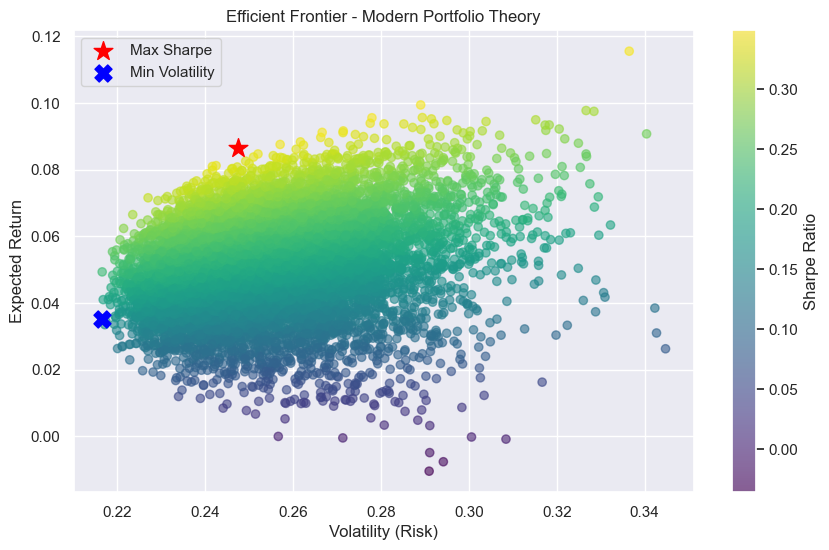

In [47]:
plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    volatility,
    returns,
    c=sharpe,
    cmap="viridis",
    alpha=0.6
)

plt.colorbar(scatter, label="Sharpe Ratio")

# Highlight optimal points
plt.scatter(
    volatility[max_sharpe_idx],
    returns[max_sharpe_idx],
    color="red",
    marker="*",
    s=200,
    label="Max Sharpe"
)

plt.scatter(
    volatility[min_vol_idx],
    returns[min_vol_idx],
    color="blue",
    marker="X",
    s=150,
    label="Min Volatility"
)

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier - Modern Portfolio Theory")
plt.legend()

plt.savefig("../results/efficient_frontier.png")
plt.show()


In [48]:
optimal_df.to_csv("../results/optimal_weights.csv", index=False)


In [49]:
optimal_df["Weight"].sum()


np.float64(0.9999999999999999)